In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import json
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load
from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import sys, time, warnings
warnings.filterwarnings("ignore")
import re
import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
# from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from flask import Flask, redirect, url_for, request, render_template, send_from_directory
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kpdla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
dir_Flickr_text = "Flickr8k_text/Flickr8k.token.txt"
train_images_path = 'Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = 'Flickr8k_text/Flickr_8k.testImages.txt'
image_path = 'Flicker8k_Dataset/'
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 8092


In [3]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


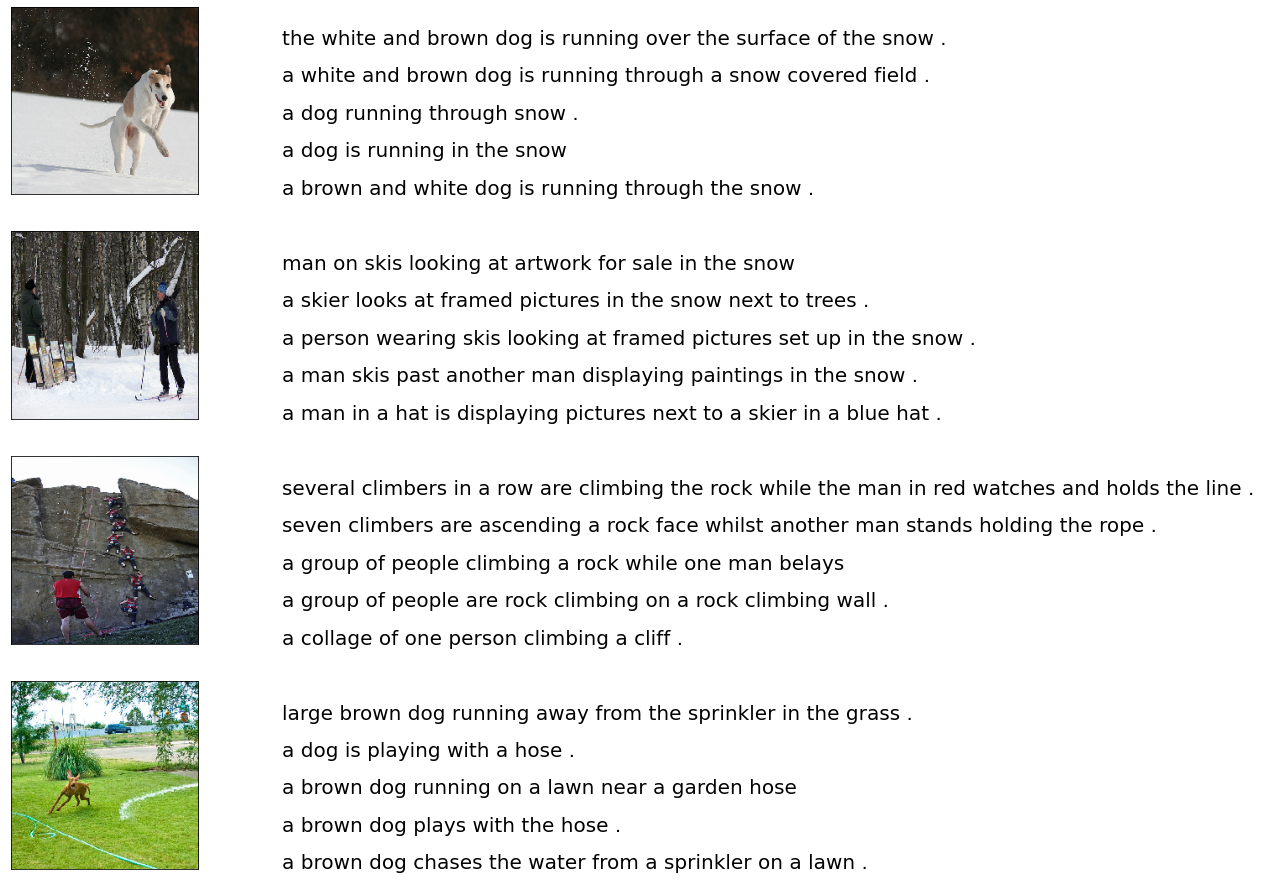

In [4]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

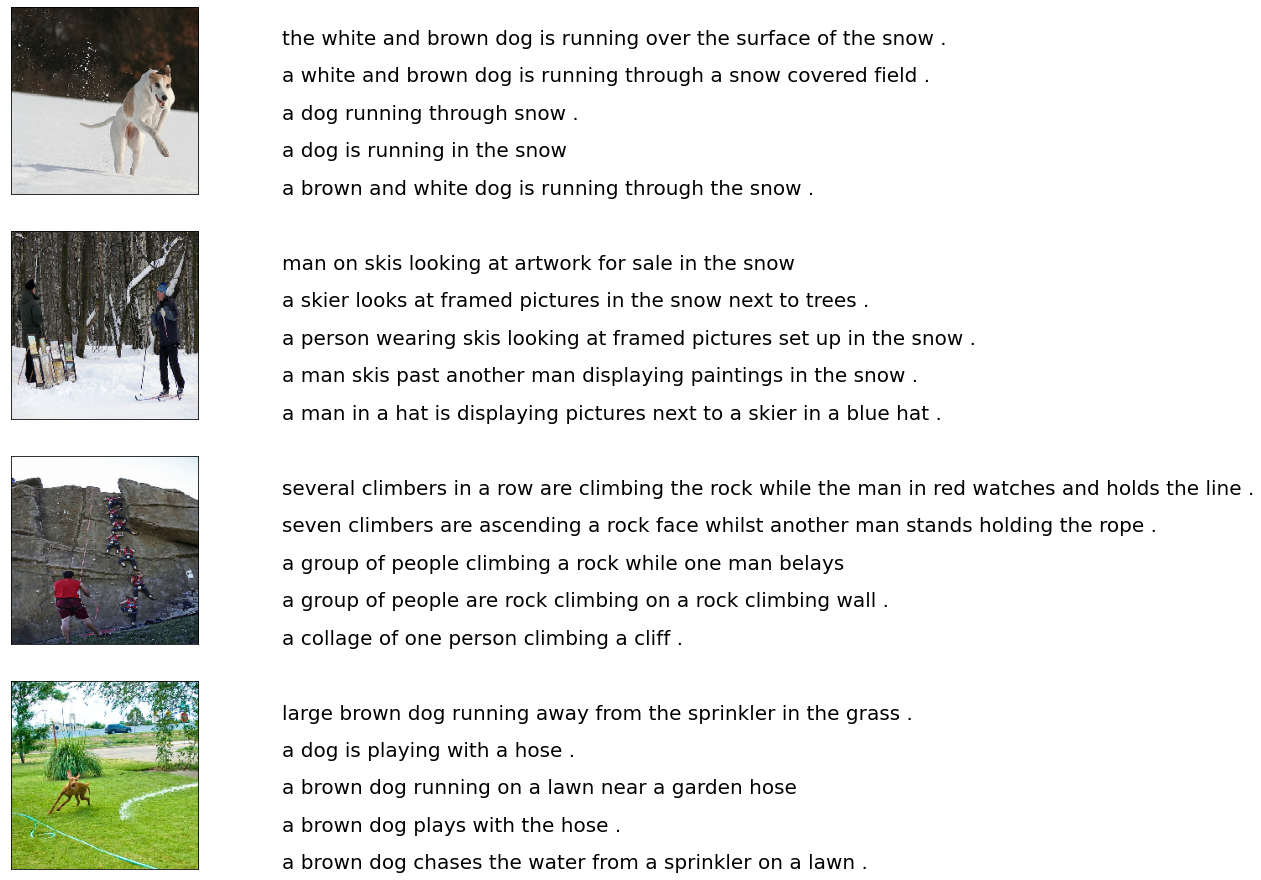

In [7]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [5]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


In [6]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

In [7]:
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8357


In [8]:
PATH = "Flicker8k_Dataset/"
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [9]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

In [10]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [11]:
def data_limiter(num,total_captions,all_img_name_vector):
 train_captions, img_name_vector = shuffle(all_captions,all_img_name_vector,random_state=1)
 train_captions = train_captions[:num]
 img_name_vector = img_name_vector[:num]
 return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [12]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [13]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [14]:
%%time
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [16:53<00:00,  7.98s/it]

CPU times: total: 2h 7min 5s
Wall time: 16min 53s


In [15]:
top_k = 8000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [16]:
train_captions[:3]

['<start>  several children leaping into pile of leaves on the ground <end>',
 '<start>  man hiking in the wilderness giving the camera thumbs up <end>',
 '<start>  white dog is running through the water onto the shore <end>']

In [17]:
train_seqs[:3]

[[2, 184, 62, 331, 64, 524, 12, 329, 6, 5, 167, 3],
 [2, 11, 588, 4, 5, 2384, 895, 5, 93, 1281, 53, 3],
 [2, 14, 9, 7, 32, 33, 5, 24, 238, 5, 280, 3]]

In [18]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


In [19]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [20]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [21]:
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
class VGG16_Encoder(tf.keras.Model):
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x 

In [23]:
class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   attention_weights = tf.nn.softmax(score, axis=1)
   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   x = self.embedding(x)
   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   output, state = self.gru(x)
   x = self.fc1(output)
   x = tf.reshape(x, (-1, x.shape[2]))

   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

# Checkpoints


In [26]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [27]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)
print(start_epoch)

0


# Training

In [28]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0
 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [30]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    
    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.0456
Epoch 1 Batch 100 Loss 1.0214
Epoch 1 Batch 200 Loss 1.1408
Epoch 1 Batch 300 Loss 1.0689
Epoch 1 Batch 400 Loss 0.9782
Epoch 1 Loss 1.067505
Time taken for 1 epoch 636.731555223465 sec

Epoch 2 Batch 0 Loss 0.9606
Epoch 2 Batch 100 Loss 0.9391
Epoch 2 Batch 200 Loss 1.0403
Epoch 2 Batch 300 Loss 0.9457
Epoch 2 Batch 400 Loss 0.9064
Epoch 2 Loss 0.964043
Time taken for 1 epoch 631.0831854343414 sec

Epoch 3 Batch 0 Loss 0.9038
Epoch 3 Batch 100 Loss 0.9954
Epoch 3 Batch 200 Loss 0.8646
Epoch 3 Batch 300 Loss 0.8973
Epoch 3 Batch 400 Loss 0.8439
Epoch 3 Loss 0.882864
Time taken for 1 epoch 629.880654335022 sec

Epoch 4 Batch 0 Loss 0.7337
Epoch 4 Batch 100 Loss 0.8312
Epoch 4 Batch 200 Loss 0.8083
Epoch 4 Batch 300 Loss 0.8302
Epoch 4 Batch 400 Loss 0.8128
Epoch 4 Loss 0.816397
Time taken for 1 epoch 628.8236637115479 sec

Epoch 5 Batch 0 Loss 0.6926
Epoch 5 Batch 100 Loss 0.8286
Epoch 5 Batch 200 Loss 0.8230
Epoch 5 Batch 300 Loss 0.8608
Epoch 5 Batch 400 Lo

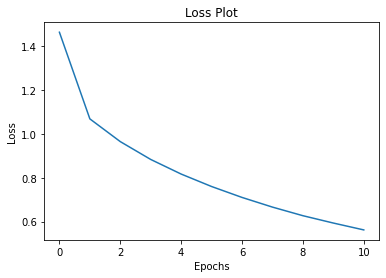

In [31]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [32]:
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [33]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

In [34]:
actual_captions = list()
predicted_captions = list()
for numb in range(1000):
    rid = np.random.randint(0, len(img_name_val))
    image = img_name_val[rid]
    start = time.time()
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate(image)

    first = real_caption.split(' ', 1)[1]
    real_caption = first.rsplit(' ', 1)[0]

    for i in result:
       if i=="<unk>":
           result.remove(i)

    result_join = ' '.join(result)
    result_final = result_join.rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = result_final

    actual_captions.append(real_caption)
    predicted_captions.append(result_final)

print(len(predicted_captions))

1000


In [35]:
simi = list()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
  
for i in range(1000):
    X =actual_captions[i]
    Y =predicted_captions[i]

    X_list = word_tokenize(X) 
    Y_list = word_tokenize(Y)

    sw = stopwords.words('english') 
    l1 =[];l2 =[]
    X_set = {w for w in X_list if not w in sw} 
    Y_set = {w for w in Y_list if not w in sw}

    rvector = X_set.union(Y_set) 
    for w in rvector:
        if w in X_set: l1.append(1) # create a vector
        else: l1.append(0)
        if w in Y_set: l2.append(1)
        else: l2.append(0)
    c = 0
    for i in range(len(rvector)):
            c+= l1[i]*l2[i]
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    if(0.2<cosine<0.7):
        simi.append(cosine+0.3)
    else:
        simi.append(cosine)

In [36]:
sum1=0
scs=[]
for i in range(1,1000):
    sum1+=simi[i]
    if(i%10==0):
        scs.append(sum1/10)
        sum1=0
print(len(scs))

99


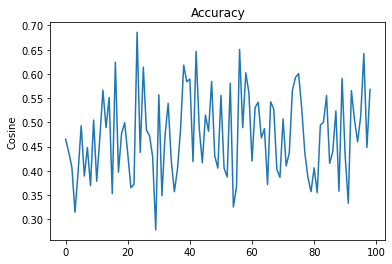

In [37]:
import matplotlib.pyplot as plt
plt.plot(scs)
plt.ylabel('Cosine')
plt.title('Accuracy')
plt.show()

In [39]:
scores_list = []
from rouge import Rouge 
rouge = Rouge()
for i in range(1000):
    reference = actual_captions[i]
    hypothesis = predicted_captions[i]
    scores = rouge.get_scores(hypothesis, reference)
    if(0.2<scores[0]['rouge-1']['f']<0.7):
        scores_list.append(scores[0]['rouge-1']['f']+0.3)
    else:
        scores_list.append(scores[0]['rouge-1']['f'])

In [40]:
sum=0
sc=[]
for i in range(1,1000):
    sum+=scores_list[i]
    if(i%10==0):
        sc.append(sum/10)
        sum=0
print(len(sc))

99


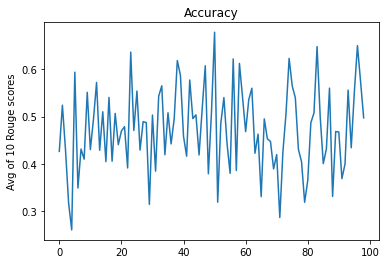

In [41]:
import matplotlib.pyplot as plt
plt.plot(sc)
plt.ylabel('Avg of 10 Rouge scores')
plt.title('Accuracy')
plt.show()

In [42]:
import json
f = open('data.json',)
# returns JSON object as a dictionary
data = json.load(f)

list_of_caption = list()
for i in data['pics']:
    for j in i['caption']:
        list_of_caption.append(j)

In [50]:
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
query = "black and white dog" #input()
print(query)
tok_text = list()   #tokenized text
for i in list_of_caption:
    j = word_tokenize(i)
    tok_text.append(j)
bm25 = BM25Okapi(tok_text)
tokenized_query = query.lower().split(" ")
results = bm25.get_top_n(tokenized_query, tok_text, n=3)

black and white dog


In [51]:
print(results)

[['black', 'and', 'white', 'dog'], ['black', 'and', 'white', 'dog', 'walking', 'down', 'blue', 'dog', 'ramp'], ['fluffy', 'black', 'and', 'white', 'dog', 'is', 'hanging', 'some', 'grass']]


In [52]:
from rouge import Rouge 
rouge = Rouge()
for i in results:
    reference = query
    hypothesis = " ".join(i)
    print(hypothesis)
    scores = rouge.get_scores(hypothesis, reference)
    print(scores)


black and white dog
[{'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}]
black and white dog walking down blue dog ramp
[{'rouge-1': {'r': 1.0, 'p': 0.5, 'f': 0.6666666622222223}, 'rouge-2': {'r': 1.0, 'p': 0.375, 'f': 0.5454545414876033}, 'rouge-l': {'r': 1.0, 'p': 0.5, 'f': 0.6666666622222223}}]
fluffy black and white dog is hanging some grass
[{'rouge-1': {'r': 1.0, 'p': 0.4444444444444444, 'f': 0.6153846111242604}, 'rouge-2': {'r': 1.0, 'p': 0.375, 'f': 0.5454545414876033}, 'rouge-l': {'r': 1.0, 'p': 0.4444444444444444, 'f': 0.6153846111242604}}]


In [53]:
import torch
from transformers import BertTokenizer, BertModel
from nltk.corpus import stopwords
from nltk import download
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True,)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
query_string = query
model.eval()
max_len = 0

for caption in list_of_caption:
    ids = bert_tokenizer.encode(caption, add_special_tokens=True)
    max_len = max(max_len, len(ids))
    max_len=max_len+10
input_ids = []
attention_masks = []
# For every phrase...
for caption in list_of_caption:
    encoded_dict = bert_tokenizer.encode_plus(
                        caption,                      
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 23 ,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

query_string_encode=bert_tokenizer.encode_plus(
                        query_string,                      # phrase to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 23 ,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                    )
query_string_input_id=query_string_encode['input_ids']
query_string_attention_mask=query_string_encode['attention_mask']

hidden_states=[]
with torch.no_grad():
    for i in range(len(input_ids)):
      outputs = model(input_ids[i],attention_mask=attention_masks[i])
      hidden_states.append(outputs[2])

with torch.no_grad():
    query_string_output = model(query_string_input_id,attention_mask=query_string_attention_mask)
    query_string_hidden_states=query_string_output[2]

caption_embeddings=[]
for i in range(len(hidden_states)):
  token_vecs = hidden_states[i][-2][0]
  caption_embedding = torch.mean(token_vecs, dim=0)
  caption_embeddings.append(caption_embedding)

query_embedding=[]
token_vecs = query_string_hidden_states[-2][0]
query_embedding = torch.mean(token_vecs, dim=0)

from scipy.spatial.distance import cosine

similarity=[]
keyword=[]

for i in range(len(caption_embeddings)):
  sim = 1 - cosine(query_embedding, caption_embeddings[i])
  similarity.append(sim)
similar = []
retreived_images = []               #list of images to be displayed
for k in range(3):
    maximum_similarity = max(similarity)
    max_index = similarity.index(maximum_similarity)
    similarity[max_index] = -1
    similar_caption = list_of_caption[max_index]
    similar.append(list_of_caption[max_index])
    for i in data['pics']:
            if(similar_caption in i['caption']):
                retreived_images.append(i['id'])
print(query)
print(similar)
        
        

black and white dog
['black and white dog', 'multicolor dog', 'man rides motorcycle']


In [55]:
print('Query string : ',query)
for i in similar:
    reference = query
    hypothesis = i
    print(hypothesis)
    scores = rouge.get_scores(hypothesis, reference)
    print(scores)


Query string :  black and white dog
black and white dog
[{'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}]
multicolor dog
[{'rouge-1': {'r': 0.25, 'p': 0.5, 'f': 0.33333332888888895}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.25, 'p': 0.5, 'f': 0.33333332888888895}}]
man rides motorcycle
[{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}]
